# Bayesian Networks with PyMC3, NetworkX, and PMML
#### Example taken from Manufacturing Uncertainty with Bayesian Networks *(S. Nannapaneni et al. 2016)*

In [6]:
## For debbugging
%load_ext autoreload

In [12]:
## for debugging:
%aimport pmml.bn
%aimport pymcnet.net
%aimport pymcnet.expr_parse
%autoreload 1
# from pymcnet.net import *
# from pmml.bn import *  # for reading in PMML (future)

In [3]:
import pandas as pd
import seaborn as sns
sns.set_style('ticks')
import matplotlib.pyplot as plt
%matplotlib inline

![weld](./weld.PNG)

The Volume of a weld is given as 
$$V = L\left(\frac{3}{4}lh+gt+\frac{l-g}{2}(t-e)\right)$$
Where V and L represent the volume of the weld and the length of the weld respectively. Assuming the filler and metal are the same material, we model the theoretical enery required for the weld process to be given as 

$$E_{AP}^{TR} = \rho(C_p(T_f-T_i)+H)V $$

where $E$, $\rho$, $C_p$, $T_f$, $T_i$, $H$ represent the theoretical minimum energy, density of the material, heat capacity, final and initial temperatures, and latent heat of the material

This can be codified as a Bayes Net. We assume that the dimensioning parameters $l$, $h$, $e$ are random variables, each with unknown distribution parameters $\mu$, $\sigma$ (assuming they are Normally distributed). 

![net](./weldBN.PNG)
In addition, we have observed values for $l$, $h$, $e$, allowing us to update the posterior distribution using MCMC (Or, in the case of PyMC3, the No-U-Turn Sampler a.k.a. NUTS)

### Sampling the prior and posterior
To get an approximation for our current belief in the distribution for minimum energy usage, we will perform sampling without any observations, and then we will add observation attributes to the network

#### First, we need some "observed data"

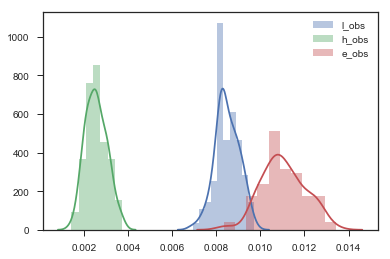

In [4]:
from scipy.stats import norm

# Synthetic Data-set (observations)
np.random.seed(19806) #random.org

num_obs = 100
l_obs = norm(8.5*1e-3, 0.5*1e-3).rvs(size=100)
h_obs = norm(2.6*1e-3, 0.5*1e-3).rvs(size=100)
e_obs = norm(11.*1e-3, 1.*1e-3).rvs(size=100)
synth = pd.DataFrame(data=np.array([l_obs, h_obs, e_obs]).T, 
                     columns=['l','h','e'])
for i in [l_obs, h_obs, e_obs]:
    sns.distplot(i)
plt.legend([
    'l_obs',
    'h_obs',
    'e_obs'
])

#### The unobserved (a.k.a. "prior") network: 

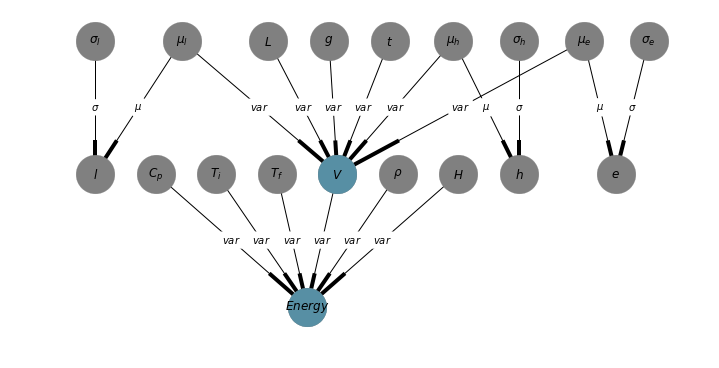

In [45]:
# import theano.tensor as T
D = BayesianNetwork()

D.add_node('mu_l', dist = pm.Uniform,
           lower=8.3e-3, upper=8.6e-3,
           dist_type='Uniform')
D.add_node('sd_l', dist = pm.Uniform,
           lower=0.2e-3, upper=0.7e-3,
           dist_type='Uniform')
D.add_node('l', dist=pm.Normal,
           mu=lambda : D.d('mu_l'),
           sd=lambda: D.d('sd_l'),
           dist_type='Normal',
#            observed=synth['l'],
           exprs = {'mu':'mu_l','sd':'sd_l'})
D.add_edge('mu_l','l', var='mu')
D.add_edge('sd_l', 'l', var='sd')

D.add_node('mu_h', dist = pm.Uniform,
           lower=2.5e-3, upper=2.8e-3,
           dist_type='Uniform')
D.add_node('sd_h', dist = pm.Uniform,
           lower=0.3e-3, upper=0.6e-3,
           dist_type='Uniform')
D.add_node('h', dist=pm.Normal,
           mu=lambda: D.d('mu_h'),
           sd=lambda: D.d('sd_h'),
           dist_type='Normal',
#            observed=synth['h'],
           exprs = {'mu':'mu_h','sd':'sd_h'})
D.add_edge('mu_h','h', var='mu')
D.add_edge('sd_h', 'h', var='sd')

D.add_node('mu_e', dist = pm.Uniform,
           lower=10e-3, upper=13e-3,
           dist_type='Uniform')
D.add_node('sd_e', dist = pm.Uniform,
           lower=0.8e-3, upper=1.3e-3,
           dist_type='Uniform')
D.add_node('e', dist=pm.Normal,
           mu=lambda: D.d('mu_e'),
           sd=lambda: D.d('sd_e'),
           dist_type='Normal',
#            observed=synth['e'],
           exprs = {'mu':'mu_e','sd':'sd_e'})
D.add_edge('mu_e','e', var='mu')
D.add_edge('sd_e', 'e', var='sd')

D.add_node('L', dist = pm.Normal,
           mu=500e-3, sd=10e-3,
           dist_type='Normal')
D.add_node('g', dist = pm.Normal,
           mu=2e-3, sd=0.1e-3,
           dist_type='Normal')
D.add_node('t', dist = pm.Normal,
           mu=15e-3, sd=0.5e-3,
           dist_type='Normal')


def vol_p():
    return D.d('L')*((3./4.)*D.d('mu_l')*D.d('mu_h') +\
                     D.d('g')*D.d('t') +\
                     (D.d('mu_l')-D.d('g'))*(D.d('t')-D.d('mu_e'))/2.)

D.add_node('V', dist=pm.Deterministic,
           var =  vol_p,
           dist_type='Deterministic',
           exprs = {'var':'L*((0.75)*mu_l*mu_h + g*t + (mu_l-g)*(t-mu_e)*0.5)'})
D.add_edges_from([(i,'V') for i in ['L', 'mu_l','mu_h','g','t','mu_e']],
                 var='var')

D.add_node('rho', dist=pm.Normal,
           mu=8238., sd=10.,
          dist_type='Normal')
D.add_node('H', dist=pm.Normal,
           mu=270e3, sd=3e3,
           dist_type='Normal')
D.add_node('C_p', dist=pm.Normal,
           mu=500., sd=5.,
           dist_type='Normal')
D.add_node('T_i', dist=pm.Normal,
           mu=303., sd=.3,
           dist_type='Normal'),
D.add_node('T_f', dist=pm.Normal,
           mu=1628., sd=10.,
           dist_type='Normal')


def nrg():
    return D.d('rho')*(D.d('C_p')*(D.d('T_f')-D.d('T_i')) +\
                           D.d('H'))*D.d('V')
D.add_node('Energy', dist=pm.Deterministic,
           var = nrg,
           dist_type = 'Deterministic',
           exprs={'var':'rho*(C_p*(T_f-T_i) + H)*V'})

D.add_edges_from([(i, 'Energy') for i in ['rho', 'C_p',
                                         'T_f', 'T_i',
                                         'H', 'V']], var='var')


draw_net(D, pretty=True)

#### The observations can be easily added in: 
Note the graph visualization automatically checks for observed nodes

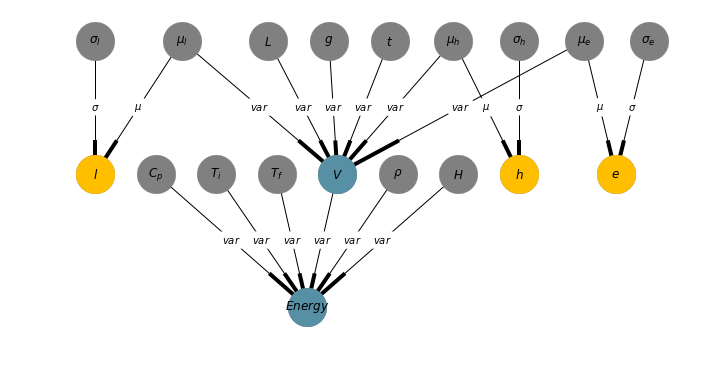

In [44]:
# import theano.tensor as T
O = BayesianNetwork()

O.add_node('mu_l', dist = pm.Uniform,
           lower=8.3e-3, upper=8.6e-3,
           dist_type='Uniform')
O.add_node('sd_l', dist = pm.Uniform,
           lower=0.2e-3, upper=0.7e-3,
           dist_type='Uniform')
O.add_node('l', dist=pm.Normal,
           mu=lambda : O.d('mu_l'),
           sd=lambda: O.d('sd_l'),
           dist_type='Normal',
           observed=synth['l'],  #    <--------------
           exprs = {'mu':'mu_l','sd':'sd_l'})
O.add_edge('mu_l','l', var='mu')
O.add_edge('sd_l', 'l', var='sd')

O.add_node('mu_h', dist = pm.Uniform,
           lower=2.5e-3, upper=2.8e-3,
           dist_type='Uniform')
O.add_node('sd_h', dist = pm.Uniform,
           lower=0.3e-3, upper=0.6e-3,
           dist_type='Uniform')
O.add_node('h', dist=pm.Normal,
           mu=lambda: O.d('mu_h'),
           sd=lambda: O.d('sd_h'),
           dist_type='Normal',
           observed=synth['h'],  #    <--------------
           exprs = {'mu':'mu_h','sd':'sd_h'})
O.add_edge('mu_h','h', var='mu')
O.add_edge('sd_h', 'h', var='sd')

O.add_node('mu_e', dist = pm.Uniform,
           lower=10e-3, upper=13e-3,
           dist_type='Uniform')
O.add_node('sd_e', dist = pm.Uniform,
           lower=0.8e-3, upper=1.3e-3,
           dist_type='Uniform')
O.add_node('e', dist=pm.Normal,
           mu=lambda: O.d('mu_e'),
           sd=lambda: O.d('sd_e'),
           dist_type='Normal',
           observed=synth['e'],  #    <--------------
           exprs = {'mu':'mu_e','sd':'sd_e'})
O.add_edge('mu_e','e', var='mu')
O.add_edge('sd_e', 'e', var='sd')

O.add_node('L', dist = pm.Normal,
           mu=500e-3, sd=10e-3,
           dist_type='Normal')
O.add_node('g', dist = pm.Normal,
           mu=2e-3, sd=0.1e-3,
           dist_type='Normal')
O.add_node('t', dist = pm.Normal,
           mu=15e-3, sd=0.5e-3,
           dist_type='Normal')


def vol_p():
    return O.d('L')*((3./4.)*O.d('mu_l')*O.d('mu_h') +\
                     O.d('g')*O.d('t') +\
                     (O.d('mu_l')-O.d('g'))*(O.d('t')-O.d('mu_e'))/2.)

O.add_node('V', dist=pm.Deterministic,
           var =  vol_p,
           dist_type='Deterministic',
           exprs = {'var':'L*((0.75)*mu_l*mu_h + g*t + (mu_l-g)*(t-mu_e)*0.5)'})
O.add_edges_from([(i,'V') for i in ['L', 'mu_l','mu_h','g','t','mu_e']],
                 var='var')

O.add_node('rho', dist=pm.Normal,
           mu=8238., sd=10.,
          dist_type='Normal')
O.add_node('H', dist=pm.Normal,
           mu=270e3, sd=3e3,
           dist_type='Normal')
O.add_node('C_p', dist=pm.Normal,
           mu=500., sd=5.,
           dist_type='Normal')
O.add_node('T_i', dist=pm.Normal,
           mu=303., sd=.3,
           dist_type='Normal'),
O.add_node('T_f', dist=pm.Normal,
           mu=1628., sd=10.,
           dist_type='Normal')


def nrg():
    return O.d('rho')*(O.d('C_p')*(O.d('T_f')-O.d('T_i')) +\
                           O.d('H'))*O.d('V')
O.add_node('Energy', dist=pm.Deterministic,
           var = nrg,
           dist_type = 'Deterministic',
           exprs={'var':'rho*(C_p*(T_f-T_i) + H)*V'})

O.add_edges_from([(i, 'Energy') for i in ['rho', 'C_p',
                                         'T_f', 'T_i',
                                         'H', 'V']], var='var')


draw_net(O, pretty=True)

#### Instantiation (i.e. Theano Comiling) and Sampling is easy!

In [7]:
n_samp = 10000

with pm.Model() as prior_model:
    instantiate_pm(D)
    
    step = pm.Metropolis()
    trace_prior = pm.sample(n_samp, step=step)

mu_l
root node; keys:  ['upper', 'lower']
sd_l
root node; keys:  ['upper', 'lower']
l
child node; keys:  ['mu', 'sd']
mu_h
root node; keys:  ['upper', 'lower']
sd_h
root node; keys:  ['upper', 'lower']
h
child node; keys:  ['mu', 'sd']
mu_e
root node; keys:  ['upper', 'lower']
sd_e
root node; keys:  ['upper', 'lower']
e
child node; keys:  ['mu', 'sd']
L
root node; keys:  ['mu', 'sd']
g
root node; keys:  ['mu', 'sd']
t
root node; keys:  ['mu', 'sd']
V
child node; keys:  ['var']
rho
root node; keys:  ['mu', 'sd']
H
root node; keys:  ['mu', 'sd']
C_p
root node; keys:  ['mu', 'sd']
T_i
root node; keys:  ['mu', 'sd']
T_f
root node; keys:  ['mu', 'sd']
Energy
child node; keys:  ['var']


C:\Users\tbs4\AppData\Local\Continuum\Anaconda2\lib\site-packages\pymc3\sampling.py:163: UserWarning: Instantiated step methods cannot be automatically initialized. init argument ignored.
  warnings.warn('Instantiated step methods cannot be automatically initialized. init argument ignored.')
100%|███████████████████████████████████| 10000/10000 [00:11<00:00, 853.32it/s]


In [8]:
with pm.Model() as model:
    instantiate_pm(O)
    
    step = pm.Metropolis()
    trace = pm.sample(n_samp, step=step)

mu_l
root node; keys:  ['upper', 'lower']
sd_l
root node; keys:  ['upper', 'lower']
l
child node; keys:  ['observed', 'mu', 'sd']
mu_h
root node; keys:  ['upper', 'lower']
sd_h
root node; keys:  ['upper', 'lower']
h
child node; keys:  ['observed', 'mu', 'sd']
mu_e
root node; keys:  ['upper', 'lower']
sd_e
root node; keys:  ['upper', 'lower']
e
child node; keys:  ['observed', 'mu', 'sd']
L
root node; keys:  ['mu', 'sd']
g
root node; keys:  ['mu', 'sd']
t
root node; keys:  ['mu', 'sd']
V
child node; keys:  ['var']
rho
root node; keys:  ['mu', 'sd']
H
root node; keys:  ['mu', 'sd']
C_p
root node; keys:  ['mu', 'sd']
T_i
root node; keys:  ['mu', 'sd']
T_f
root node; keys:  ['mu', 'sd']
Energy
child node; keys:  ['var']


100%|███████████████████████████████████| 10000/10000 [00:10<00:00, 999.20it/s]


#### Plot the updated belief

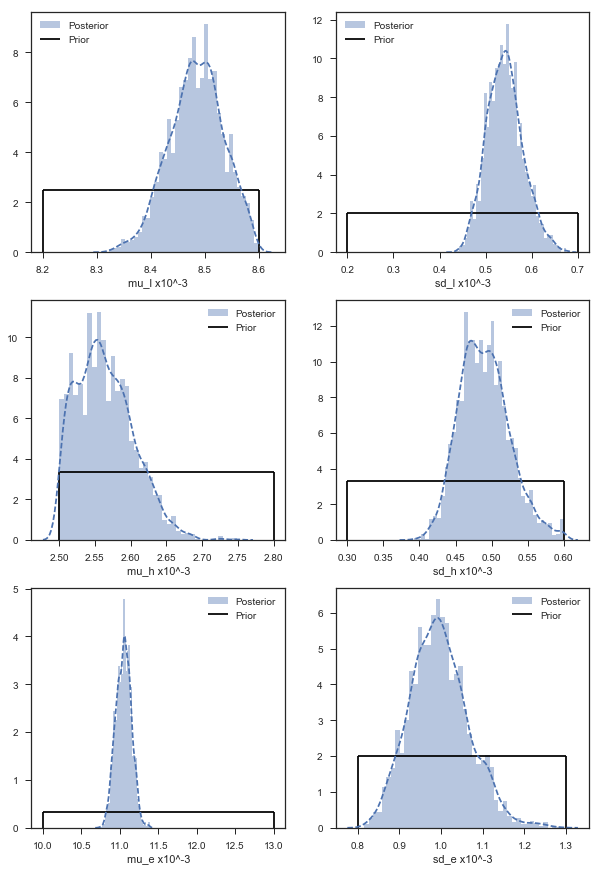

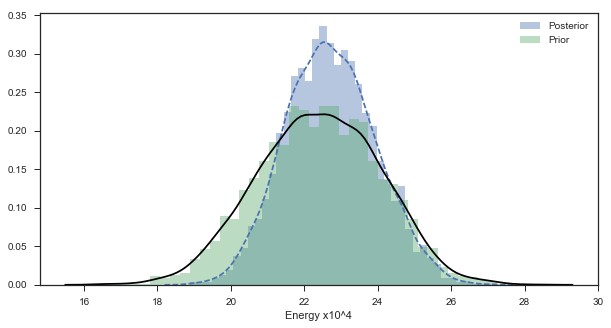

In [9]:
lims = [(8.2e-3, 8.6e-3),
        (0.2e-3, 0.7e-3),
        (2.5e-3, 2.8e-3),
        (0.3e-3, 0.6e-3),
        (10e-3, 13e-3),
        (0.8e-3, 1.3e-3)]
varnames=['mu_l', 'sd_l',
          'mu_h', 'sd_h',
          'mu_e', 'sd_e']


def compare_dist(ax, dat, lim, scale=1.):
    sns.distplot(scale*dat, ax=ax, kde=True, label='Posterior', kde_kws={'ls':'--'})
    a,b = scale*lim[0], scale*lim[1]
    y = 1./(b-a)
    ax.hlines(y=y, xmin=a, xmax=b, linestyles=u'solid', label='Prior')
    ax.vlines([a,b],ymin=0, ymax=y, linestyles=u'solid')
    ax.legend()

f, axes = plt.subplots(nrows=3, ncols=2, figsize=(10,15))

for n, ax in enumerate(axes.flat):
    compare_dist(ax, trace[n_samp/2:].get_values(D.d(varnames[n])), lims[n], scale=1e3)
    ax.set_xlabel("{} x10^{}".format(varnames[n], -3))
plt.show()

f2 = plt.figure(figsize=(10,5))
sns.distplot(trace[n_samp/2:].get_values('Energy')*1e-4, kde=True, label='Posterior', kde_kws={'ls':'--'})
sns.distplot(trace_prior[n_samp/2:].get_values('Energy')*1e-4, label='Prior', kde_kws={'color':'k'})
plt.legend()
plt.xlabel('Energy x10^{}'.format(4))
plt.show()

#### Compare to the original results: 

![paper](./paper.PNG)

#### Serialization
This model is compatible with the PMML parser in the package. To save it, just call the `toPMML()` network method 

In [10]:
O.toPMML('WeldModelPMML.xml')

mu_l
	upper 0.0086
	lower 0.0083
sd_l
	upper 0.0007
	lower 0.0002
l
	mu mu_l
	sd sd_l
mu_h
	upper 0.0028
	lower 0.0025
sd_h
	upper 0.0006
	lower 0.0003
h
	mu mu_h
	sd sd_h
mu_e
	upper 0.013
	lower 0.01
sd_e
	upper 0.0013
	lower 0.0008
e
	mu mu_e
	sd sd_e
L
	mu 0.5
	sd 0.01
g
	mu 0.002
	sd 0.0001
t
	mu 0.015
	sd 0.0005
V
	var L*((0.75)*mu_l*mu_h + g*t + (mu_l-g)*(t-mu_e)*0.5)
rho
	mu 8238.0
	sd 10.0
H
	mu 270000.0
	sd 3000.0
C_p
	mu 500.0
	sd 5.0
T_i
	mu 303.0
	sd 0.3
T_f
	mu 1628.0
	sd 10.0
Energy
	var rho*(C_p*(T_f-T_i) + H)*V
Wrote PMML file to WeldModelPMML.xml


## Reading PMML Files In (NotImplemented)

In [3]:
bnp = parsers.pmml.bn.BayesianNetworkParser()

bnp.parse('BN_eg.xml')


[<Element {http://www.dmg.org/PMML-4_3}ContinuousNode at 0x8d2aac8>, <Element {http://www.dmg.org/PMML-4_3}ContinuousNode at 0x8d2ac48>, <Element {http://www.dmg.org/PMML-4_3}ContinuousNode at 0x8d2acc8>, <Element {http://www.dmg.org/PMML-4_3}ContinuousNode at 0x8d2ad08>]
C1
C2
C4
C3


In [4]:
bnp._parse_graph()

TypeError: _parse_graph() takes exactly 2 arguments (1 given)

In [45]:
import networkx as nx
G = nx.DiGraph()

In [46]:
G.add_node(0, att = 1)
G.add_node(1, att=G.node[0]['att']+1)
G.node

{0: {'att': 1}, 1: {'att': 2}}

In [47]:
G.node[0]['att'] += 1
G.node

{0: {'att': 2}, 1: {'att': 2}}

In [42]:
from sympy import symbols, Symbol, pprint, latex
print symbols(D.nodes())
print latex(Symbol('sigma_l'))
Symbol('tau_l')

[mu_l, sd_l, l, mu_h, sd_h, h, mu_e, sd_e, e, L, g, t, V, rho, H, C_p, T_i, T_f, Energy]
\sigma_{l}


tau_l